# Get distribution of 3mer scores
We want to see how well the 3mers score against some distribution of spectra.

We will probably see a long tailed distribution, and we want to just get the most interesting ones to reduce computation. We would ideally like to do this without some hard cutoff value, so if we can use a property of the distribution that would be extra jazzy

## 1. Load fasta database

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.file_io import fasta

fasta_file = '../../testing framework/data/databases/6000prots.fasta'
database = fasta.read(fasta_file, True)

database = {x['name']: x for x in database}


## 2.  Generate the peptides, hybrid proteins and peptides

In [2]:
import modules
from modules.sequence_generation import proteins, peptides

num_hybs = 5
min_length= 5
max_length = 35
num_peptides = 6000
min_cont = 3 #min contribution for each side of a hybrid

# make hybrid proteins
hyb_prots = proteins.generate_hybrids([x for _, x in database.items()], num_hybs, min_contribution=max_length)
# create peptides
non_hybrid_peps = peptides.gen_peptides([x for _, x in database.items()], num_peptides, min_length=min_length, max_length=max_length, digest='random', dist='beta')
# create hybrid peptides
hyb_peps = peptides.gen_peptides(hyb_prots, num_hybs, min_length=min_length, max_length=max_length, digest='random', min_contribution=min_cont, hybrid_list=True)

all_proteins_raw = [x for _,x in database.items()] + hyb_prots
all_peptides_raw = non_hybrid_peps + hyb_peps

peptides = {}
for i, pep in enumerate(all_peptides_raw):
    peptides[i] = pep
    peptides[i]['scan_no'] = i

Generating hybrid protein 4/5[80%]
Finished generating hybrid proteins


## 3. Generate spectra

In [3]:
from src.spectra import gen_spectra

spectra = []
sorted_keys = [int(c) for c in peptides.keys()]
sorted_keys.sort()
for k in sorted_keys:
    pep = peptides[k]
    cont = gen_spectra.gen_spectrum(pep['sequence'])
    spec = cont['spectrum']
    pm = cont['precursor_mass']
    spectra.append({'spectrum': spec, 'precursor_mass': pm})


## 4. Run the scoring algorithm for all kmers

In [4]:
# creata and index a database
from src.database.database import Database

#self, fasta_file_name: str, is_uniprot=False, kmer_size=3
db = Database(fasta_file, True, 2)
db.index()
kmerdict = db.metadata

452 unique kmers


In [5]:
# import the scoring algorithm
from src.scoring.scoring import score_subsequence
import numpy as np

# scoring the subsequence is spectrum (list) and subseq (str)
bscores = np.zeros((len(kmerdict), len(spectra)))
yscores = np.zeros((len(kmerdict), len(spectra)))

In [6]:
for i, spec in enumerate(spectra):
    print('on spectrum {}/{}\r'.format(i, len(spectra)), end='')
    # get the score for all 
    thesebscores = []
    theseyscores = []
    for kmer in kmerdict.keys():
        b, y = score_subsequence(spec['spectrum'], kmer)
        thesebscores.append(b)
        theseyscores.append(y)
    # sort them
    thesebscores.sort(reverse=True)
    theseyscores.sort(reverse=True)
    bscores[:,i] = thesebscores
    yscores[:,i] = theseyscores

## 5. plot it

In [7]:
import matplotlib.pyplot as plt

# find the mean, standard deviation, and extremes
meanscores = lambda l: [np.mean(x) for x in l]
stddevscores = lambda l: [np.std(x) for x in l]
minscores = lambda l: [min(x) for x in l]
maxscores = lambda l: [max(x) for x in l]
totalmeanscores = lambda l: np.mean(l)
totalstandardscores = lambda l: np.std(l)
scoresabovex = lambda x, l: [y for y in l if y >= x]

In [8]:
# b plot
bmean = meanscores(bscores)
bstd = stddevscores(bscores)
bmin = minscores(bscores)
bmax = maxscores(bscores)
btotalmean = totalmeanscores(bscores) 
meanmean = [btotalmean for _ in range(len(kmerdict.keys()))]
btotalstd = totalstandardscores(bscores)
stdstd = [btotalstd for _ in range(len(kmerdict.keys()))]
btopscores = scoresabovex(btotalstd*4, [item for sublist in bscores for item in sublist])


In [9]:
stdabove = [bmean[i] + bstd[i] for i in range(len(kmerdict.keys()))]
stdbelow = [bmean[i] - bstd[i] for i in range(len(kmerdict.keys()))]

39946


Text(0.5, 1.0, 'ranked score values as a function of position')

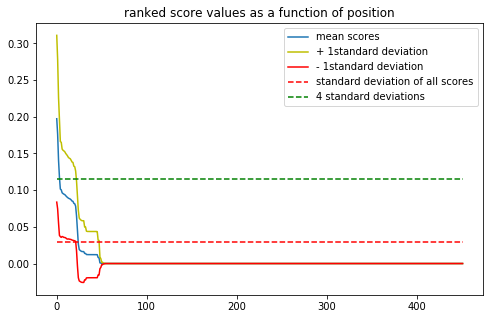

In [10]:
print(len(btopscores))
# plot it
maxrange = 1000
x = range(len(bmean))
plt.figure(figsize=(8, 5))
plt.plot(x[:maxrange], bmean[:maxrange], label='mean scores')
plt.plot(x[:maxrange], stdabove[:maxrange], 'y', label='+ 1standard deviation')
plt.plot(x[:maxrange], stdbelow[:maxrange], 'r', label='- 1standard deviation')
plt.plot(x[:maxrange], stdstd[:maxrange], 'r--', label='standard deviation of all scores')
plt.plot(x[:maxrange], [x * 4 for x in stdstd][:maxrange], 'g--', label='4 standard deviations')
plt.legend()
plt.title('ranked score values as a function of position')




